# I) General

## 1. Importations

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import random
import string
import re
import unicodedata
from time import time

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn.naive_bayes as nb

from wordcloud import WordCloud

# II) First data set french presidents

## 1. Data visualization

In [60]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8')
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [61]:
def preprocessing(X):
    res = []
    for doc in X:
        punc = string.punctuation
        punc += '\n\r\t'
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

In [62]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)[:1000]
Y = np.array(alllabs)[:1000]
X_preprocess = preprocessing(X)
X_train = formal(X_preprocess)

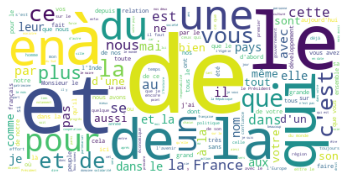

In [63]:
words = "".join(flatten(X))
wordcloud = WordCloud(background_color='white', max_words=200).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[9.99995000e-06 9.99995000e-06 9.99995000e-06 ... 6.56948143e+00
 6.72022017e+00 7.12689082e+00]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


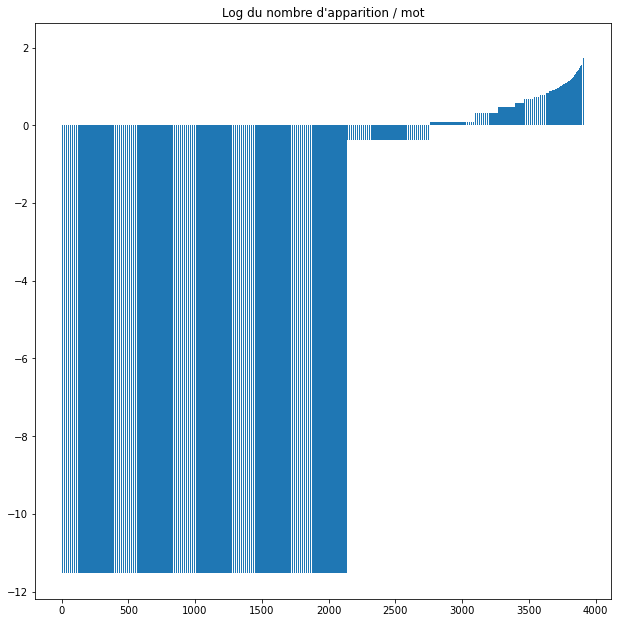

In [64]:
words = "".join(flatten(X_preprocess))
unique_words, count = np.unique(words.split(), return_counts=True)
count = np.log(count+1e-5)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(count)),np.log(count))
plt.title("Log du nombre d'apparition / mot")
plt.show()

[   1    1    1 ...  713  829 1245]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


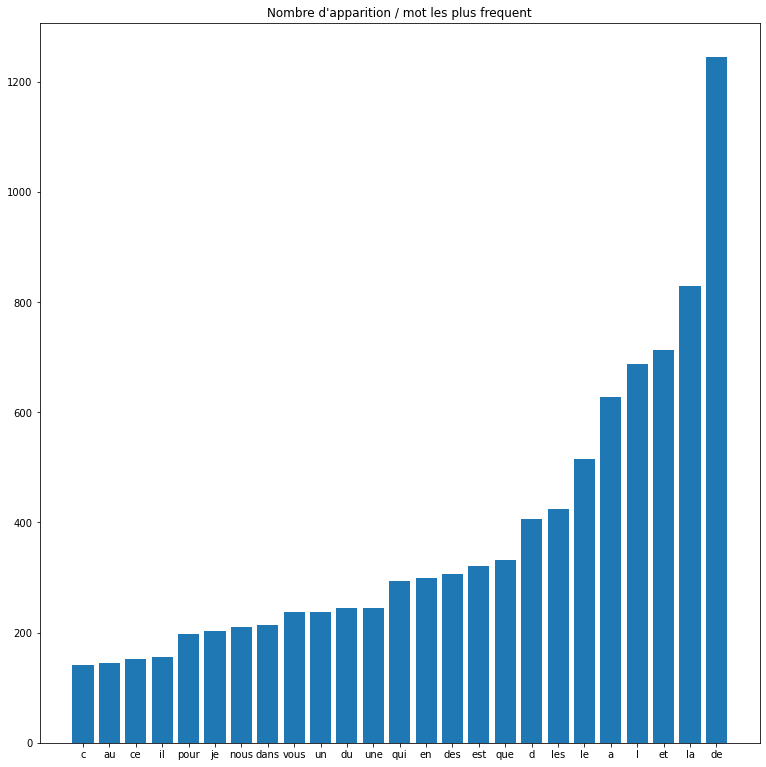

In [65]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_words[len(count)-25:],count[len(count)-25:])
plt.title("Nombre d'apparition / mot les plus frequent")
plt.show()

## 2. Features and model selection

In [74]:
def naive_balancing(X, Y):
    label, count = np.unique(Y, return_counts=True)
    idx_pos = np.where(Y == 1, True, False)
    Y_pos = Y[idx_pos]
    Y_pos = Y_pos[:count.min()]
    idx_neg = np.where(Y == -1, True, False)
    Y_neg = Y[idx_neg]
    new_Y = np.concatenate((Y_pos, Y_neg))
    new_X = np.concatenate((X[:count.min()], X[idx_neg]))    
    tmp = list(zip(new_X, new_Y))
    random.shuffle(tmp)
    new_X, new_Y = zip(*tmp)  
    label, count = np.unique(new_Y, return_counts=True)
    print(label, count)
    return new_X, new_Y

def get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer=None):
    X_vector = vectorizer.fit_transform(X)
    if transformer is not None:
        transformer = transformer.fit(X_vector)
        X_final = transformer.transform(X_vector)
    else:
        X_final = X_vector
    X_test_vector = vectorizer.transform(X_test)
    return X_final, X_test_vector, Y, Y_test

def get_inf_acc(predictions, Y_test):
    idx_inf = np.where(predictions==-1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def get_sup_acc(predictions, Y_test):
    idx_inf = np.where(predictions==1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def display_infos(clf, X_test, Y_test):
    # Check le nombre de predictions pour chaque label
    predictions = clf.predict(X_test)
    unique, counts = np.unique(predictions, return_counts=True)
    print("/!\ Prediction counts for label ", unique, " --> ", counts)
    # Check le nombre de predictions pour chaque label
    unique, counts = np.unique(Y_test, return_counts=True)
    print("/!\ Ground truth counts for label ", unique, " --> ", counts)
    # Check la precision du label en inferiorite
    acc = get_inf_acc(predictions, Y_test)
    print("/!\ Accuracy of inferior label :", acc, "%")
    # Check la precision du label en superiorite
    acc = get_sup_acc(predictions, Y_test)
    print("/!\ Accuracy of superior label :", acc, "%\n")
    
def display_model_scores(model, X_test, Y_test):
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(best_parameters.keys()):
        print("--->%s: %r" % (param_name, best_parameters[param_name]))
    # print(model.best_score_)
    grid_predictions = model.predict(X_test)
    print(confusion_matrix(Y_test, grid_predictions))
    print(classification_report(Y_test, grid_predictions))
    
def stemm(X):
    stemmer = SnowballStemmer("french")
    stem = stemmer.stem(X)
    return X

### --> Loading and splitting data

In [67]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)
# new_X, new_Y = naive_balancing(X,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) # Test avec new_X, new_Y
train_size = len(X_train)
test_size = len(X_test)
print(train_size)
print(test_size)

45930
11483


### --> Stemming

In [68]:
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

### --> Feature selection depending the model selected

In [69]:
search = True
sw = stopwords.words('french')

if search :
    
    pipeline_svc = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LinearSVC(class_weight="balanced",
                              max_iter=2000,
                              C=100))     
        ]
    )
    pipeline_nb = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", MultinomialNB())      
        ]
    )
    pipeline_lr = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LogisticRegression(class_weight="balanced",
                                       max_iter=2000,
                                       C=100))        
        ]
    )
    parameters_vectorizer = {
        "vect__lowercase": (True, False),
        "vect__stop_words": (None, sw),
        "vect__strip_accents": (None, 'ascii'),
        # "vect__use_idf": (True,False),
        # "vect__smooth_idf": (False,True),
        # "vect__sublinear_tf": (False,True),
        
        "vect__min_df": (1, 5, 15),
        "vect__max_df": (0.01, 0.05, 0.1, 0.5, 0.9),
        "vect__ngram_range": [(1, 1), (1, 2)],
        'vect__max_features': (None,),
        }
    
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    grid_search_parameters_svc = GridSearchCV(pipeline_svc, 
                                              parameters_vectorizer, 
                                              scoring="f1", # test "rog_auc"
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_nb = GridSearchCV(pipeline_nb, 
                                              parameters_vectorizer, 
                                              scoring="f1",
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_lr = GridSearchCV(pipeline_lr, 
                                              parameters_vectorizer, 
                                              scoring="f1", 
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    
    print("===================================== SVC + VECTORIZER =====================================")
    t0 = time()
    grid_search_parameters_svc.fit(X_train, Y_train) # test and compare f1 score if pipeline 1 -> pipeline 2 or pipeline 2 -> pipeline 1
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_svc, X_train, Y_train) # Verifier pas trop d'overfit sur le X_train
    display_model_scores(grid_search_parameters_svc, X_test, Y_test) # Verifier que c'est bien notre X_test
    
    print("===================================== NB + VECTORIZER =====================================")
    t0 = time()
    grid_search_parameters_nb.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_nb, X_train, Y_train)
    display_model_scores(grid_search_parameters_nb, X_test, Y_test) 
    
    print("===================================== LR + VECTORIZER =====================================")
    t0 = time()
    grid_search_parameters_lr.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_lr, X_train, Y_train)
    display_model_scores(grid_search_parameters_lr, X_test, Y_test) 

===================================== SVC + VECTORIZER =====================================
Fitting 3 folds for each of 240 candidates, totalling 720 fits


C:\Users\karna\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


done in 1493.525s
--->cv: StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
--->error_score: nan
--->estimator: Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 LinearSVC(C=100, class_weight='balanced', max_iter=2000))])
--->estimator__clf: LinearSVC(C=100, class_weight='balanced', max_iter=2000)
--->estimator__clf__C: 100
--->estimator__clf__class_weight: 'balanced'
--->estimator__clf__dual: True
--->estimator__clf__fit_intercept: True
--->estimator__clf__intercept_scaling: 1
--->estimator__clf__loss: 'squared_hinge'
--->estimator__clf__max_iter: 2000
--->estimator__clf__multi_class: 'ovr'
--->estimator__clf__penalty: 'l2'
--->estimator__clf__random_state: None
--->estimator__clf__tol: 0.0001
--->estimator__clf__verbose: 0
--->estimator__memory: None
--->estimator__steps: [('vect', TfidfVectorizer()), ('clf', LinearSVC(C=100, class_weight='balanced', max_iter=2000))]
--->estimator__vect: TfidfVectorizer()
--->estimator__vect__analyzer: '

In [76]:
# display_model_scores(grid_search_parameters_svc, X_test, Y_test)
# display_model_scores(grid_search_parameters_nb, X_test, Y_test)
# display_model_scores(grid_search_parameters_lr, X_test, Y_test)

--->clf: LinearSVC(C=100, class_weight='balanced', max_iter=2000)
--->clf__C: 100
--->clf__class_weight: 'balanced'
--->clf__dual: True
--->clf__fit_intercept: True
--->clf__intercept_scaling: 1
--->clf__loss: 'squared_hinge'
--->clf__max_iter: 2000
--->clf__multi_class: 'ovr'
--->clf__penalty: 'l2'
--->clf__random_state: None
--->clf__tol: 0.0001
--->clf__verbose: 0
--->memory: None
--->steps: [('vect', TfidfVectorizer(lowercase=False, max_df=0.1, ngram_range=(1, 2))), ('clf', LinearSVC(C=100, class_weight='balanced', max_iter=2000))]
--->vect: TfidfVectorizer(lowercase=False, max_df=0.1, ngram_range=(1, 2))
--->vect__analyzer: 'word'
--->vect__binary: False
--->vect__decode_error: 'strict'
--->vect__dtype: <class 'numpy.float64'>
--->vect__encoding: 'utf-8'
--->vect__input: 'content'
--->vect__lowercase: False
--->vect__max_df: 0.1
--->vect__max_features: None
--->vect__min_df: 1
--->vect__ngram_range: (1, 2)
--->vect__norm: 'l2'
--->vect__preprocessor: None
--->vect__smooth_idf: Tru

### --> Building optimal vectorizer for each model

In [78]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 min_df=1,
                                 max_df=0.1,
                                 ngram_range=(1,2),
                                 )

vectorizer_nb = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 min_df=15,
                                 max_df=0.05,
                                 ngram_range=(1,2),
                                 )

vectorizer_lr = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 min_df=1,
                                 max_df=0.01,
                                 ngram_range=(1,2),
                                 )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_nb, X_test_vector_nb, Y_train_nb, Y_test_nb = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_nb)
print(X_train_vector_nb.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

(45930, 308214)
(45930, 12907)
(45930, 307933)


### --> Model selection SVC

In [ ]:
search = True
if search:
    parameters = {
        'C': (1,10,50,100,200,500),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(LinearSVC(class_weight="balanced",
                                         max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_svc, Y_train_svc)
    display_model_scores(optimal_svc, X_test_vector_svc, Y_test_svc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


### --> Model selection NB

In [ ]:
search = True
if search:
    parameters = {
        'alpha': np.arrange(0, 1, 0.1),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_nb = GridSearchCV(svm.MultinomialNB(),
                              parameters, 
                              scoring="f1",
                              n_jobs=8, 
                              verbose=3, 
                              cv=strat_kfold,
                              refit=True
                              )

    t0 = time()
    optimal_nb.fit(X_train_vector_nb, Y_train_nb)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_nb, X_train_vector_nb, Y_train_nb)
    display_model_scores(optimal_nb, X_test_vector_nb, Y_test_nb)

### --> Model selection LR

In [ ]:
search = True
if search:
    parameters = {
        'C': (1, 10, 50, 100, 200, 500),
        'penalty' : ("l1", "l2", "elasticnet")
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(svm.LogisticRegression(class_weight="balanced",
                                                      max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_lr, Y_train_lr)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_lr, Y_train_lr)
    display_model_scores(optimal_svc, X_test_vector_lr, Y_test_lr)

## 3. Final training on whole train dataset

In [ ]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts_train_final, alllabs_train_final = load_pres(fname)
X_train_final = np.array(alltxts_train_final)
Y_train_final = np.array(alllabs_train_final)

In [ ]:
final_vectorizer = TfidfVectorizer(lowercase=,
                                   stop_words=,
                                   strip_accents=,
                                   use_idf=,
                                   smooth_idf=,
                                   sublinear_tf=,
                             
                                   min_df=,
                                   max_df=,
                                   ngram_range=,
                                   )

X_final_vector = final_vectorizer.fit_transform(X_train_final)

final_model = ???

t0 = time()
final_model.fit(X_final_vector,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

In [ ]:
display_model_scores(final_model, X_final_vector, Y_train_final)

## 4. Computing final results 

In [ ]:
fname = "../TME1/data/corpus.tache1.test.utf8"
alltxts_test_final, alllabs_test_final = load_pres(fname)
X_test_final = np.array(alltxts_test_final)
Y_test_final = np.array(alllabs_test_final)

In [ ]:
X_test_vector = final_vectorizer.transform(X_test_final)
final_pred = final_model.predict(X_test_vector)

In [ ]:
print(final_pred.shape)

In [ ]:
f = open("../TME1/output/preds_clean.txt", "a")
preds = ""
for i in range(len(final_pred)):
    preds += str(final_pred[i])
# print(preds)
f.write(preds)
f.close()

## 5. Post processing

# III) Movie dataset

In [ ]:
def load_movies(path2data): 
    alltxts = []
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): 
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 
    return alltxts,labs

## 1. Data visualization

In [ ]:
path = "../TME1/data/movies1000/"
alltxts,alllabs = load_movies(path)
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

## 2. Feature and model selection

## 3. Final training

## 4. Computing final results

## 5. Post processing